In [1]:
import numpy as np
from jax import grad, jacrev, jacfwd, jit, vmap
import jax.numpy as jnp
import jax.scipy as jscp

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.svm import SVC

import seaborn as sns

import jax
jax.config.update("jax_platform_name", "cpu")

np.random.seed(32)

In [2]:
Phi = lambda v: jscp.stats.norm.cdf(v, loc=0, scale=1)
phi = lambda v: jscp.stats.norm.pdf(v, loc=0, scale=1)

In [3]:
def psi_g(alpha, sigma):
    return Phi((1- alpha)/sigma) * (1 - alpha) + phi((1- alpha)/sigma) * sigma

In [4]:
def L(w, X, y, sigma):
    return 1/2 * jnp.linalg.norm(w, ord=2)**2 + jnp.mean(psi_g(y * (X @ w), sigma))

In [5]:
X, y = make_blobs(n_samples=500, n_features=2, centers=[[-1,-1], [1,1]], random_state=10)
y[np.where(y == 0)] = -1

In [6]:
clf = SVC(kernel='linear').fit(X, y)
print(clf.coef_)
print(clf.intercept_)

[[1.08295544 1.3306723 ]]
[0.06209171]


In [7]:
X = np.c_[X, np.ones(X.shape[0])]

In [8]:
#init_w = np.random.rand(X.shape[1])
init_w = jnp.zeros(X.shape[1])
w = init_w

In [9]:
print(w.shape)
print(X.shape)
print(y.shape)

#print((y * (X @ w)).shape)
print(w)

(3,)
(500, 3)
(500,)
[0. 0. 0.]


In [10]:
n_iter = 300
nabla_L = grad(L)
hess_L = jacfwd(jacrev(L))
eta = 0.4
sigma = 0.01

alpha_t = 0.5/X.shape[0]

loss = L(w, X, y, sigma)
print(f"loss:{loss}")

grad_Z_f = jit(vmap(nabla_L, in_axes=(None, 0, 0, None)))
hess_Z_f = jit(vmap(hess_L, in_axes=(None, 0, 0, None)))
vmap_matmul = jit(vmap(jnp.matmul, in_axes=(0, 0)))
one_axis_matmul = jit(vmap(jnp.matmul, in_axes=(None, 0)))
w_cv = jnp.zeros((X.shape[0], X.shape[1]))
for t in range(n_iter): 
    L_grad = jnp.nan_to_num(nabla_L(w, X, y, sigma), nan=sigma)
    L_hess = jnp.nan_to_num(hess_L(w, X, y, sigma), nan=sigma)

    grad_Z = jnp.nan_to_num(grad_Z_f(w, X, y, sigma), nan=sigma)
    hess_Z = jnp.nan_to_num(hess_Z_f(w, X, y, sigma), nan=sigma)
    
    if np.any(np.isnan(grad_Z)) or np.any(np.isnan(hess_Z)):
        print(grad_Z, hess_Z)

    grad_minus = L_grad - grad_Z
    hess_minus = L_hess - hess_Z
    
    if np.any(np.isnan(grad_minus)) or np.any(np.isnan(hess_minus)):
        print(grad_minus, hess_minus)

    w_cv = (
        w_cv
        - alpha_t * grad_minus
        - alpha_t * vmap_matmul(hess_minus, (w_cv - w))
    )
    
    w -= eta * L_grad

    
loss = L(w, X, y, sigma)
print(f"loss:{loss}")

loss:1.0
loss:0.5059601068496704


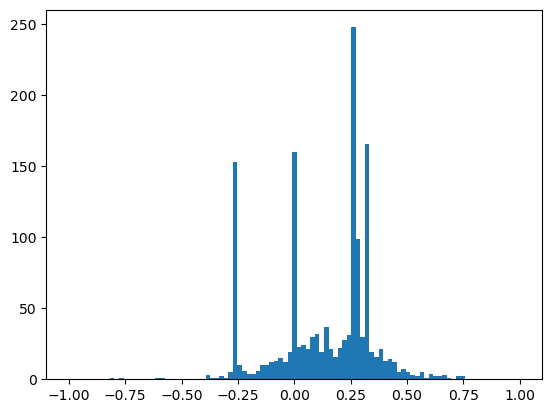

2.1376587832893192e+23


In [11]:
w_cv_clean = np.array(w_cv[~np.isnan(w_cv).any(axis=1) & ~np.isinf(w_cv).any(axis=1)], dtype=np.float64)
#w_cv_clean = w_cv_clean[(w_cv_clean[:, 0] >= -1) & (w_cv_clean[:, 0] <= 1), :]
#hst = np.histogram(w_cv_clean.ravel(), bins=np.linspace(-1, 1, 100))
plt.hist(w_cv_clean.ravel(), bins=np.linspace(-1, 1, 100))
plt.show()
print(np.max(w_cv_clean))

In [12]:
print(np.mean(w_cv_clean, axis=0))
print(np.median(w_cv_clean, axis=0))
print(w)
sk_coef = [*clf.coef_[0], clf.intercept_[0]] 
#print(sk_coef)
print(sk_coef/np.sum(sk_coef))

[ 2.76834548e+19 -1.16354820e+21  3.69780236e+20]
[0.25012877 0.29304327 0.00586272]
[0.3705961  0.428266   0.01131266]
[0.4374306  0.53748913 0.02508027]


In [13]:
def plot_line(theta, label, color, **kwargs):
    a = -theta[0] / theta[1]
    yy = a * xx - theta[2] / theta[1]
    plt.plot(xx, yy, label=label, c=color, **kwargs)

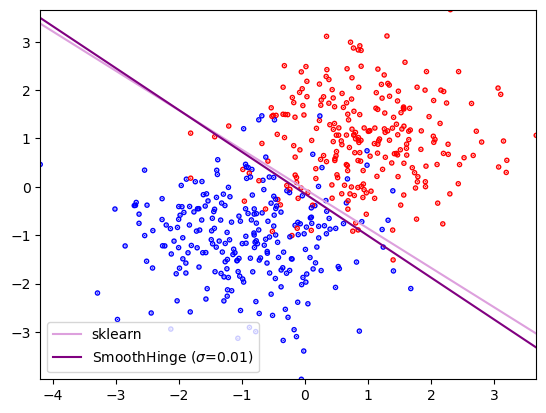

In [14]:
def plot_line(theta, label, color, **kwargs):
    a = -theta[0] / theta[1]
    yy = a * xx - clf.intercept_[0] / theta[1]
    plt.plot(xx, yy, label=label, c=color, **kwargs)

xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
plt.scatter(*X.T, c=y, cmap=plt.cm.bwr, linewidths=3)

plot_line([*clf.coef_[0], clf.intercept_[0]], "sklearn", "plum")
plot_line(w, f"SmoothHinge ($\sigma$={sigma})", "purple")

plt.xlim(np.min(X[:, 0]), np.max(X[:, 0]))
plt.ylim(np.min(X[:, 1]), np.max(X[:, 1]))
plt.legend()

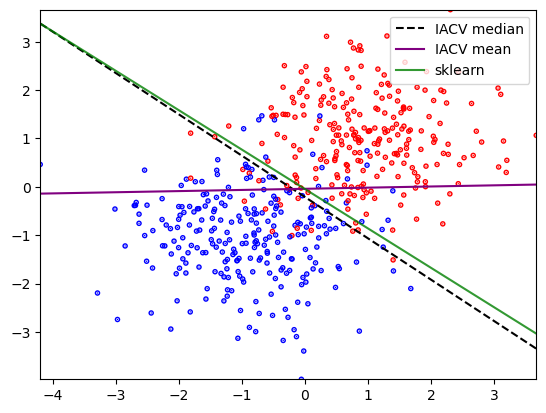

In [15]:
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
plt.scatter(*X.T, c=y, cmap=plt.cm.bwr, linewidths=3)

median_w = np.median(w_cv_clean, axis=0)
plot_line(median_w, "IACV median", "black", linestyle='--')

mean_w = np.mean(w_cv_clean, axis=0)
mean_w /= np.sum(mean_w)
plot_line(mean_w, "IACV mean", "purple")

plot_line([*clf.coef_[0], clf.intercept_[0]], "sklearn", "green", alpha=0.8)

plt.xlim(np.min(X[:, 0]), np.max(X[:, 0]))
plt.ylim(np.min(X[:, 1]), np.max(X[:, 1]))
plt.legend()